# Exploring Dynamic Mode Decomposition
*by Yash Bhora*

In [7]:
# importing necessary dependencies and setting config
from mat4py import loadmat
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pydmd import DMD
from pydmd.plotter import plot_eigs
import scipy
import warnings
from pydmd.bopdmd import BOPDMD
import copy
import pickle
from sklearn.preprocessing import normalize

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")

## Abstract

With the rise of big data, it is important from a computational standpoint to effectively extract low-rank information from high dimensional structures like data matrices. To relieve this challenge, several dimensionaly reduction techniques have been pioneered like Singular Value Decomposition (SVD), Principal Component Analysis (PCA), and Dynamic Mode Decomposition (DMD). This final project primarily explores DMD, which reduces data into its spatial modes and associated temporal dynamics. To illustrate its capabilities, it is applied to Electrocorticography (ECG) recordings in the domain of neuroscience. Variations of DMD, like Bagging, Optimized DMD (BOPDMD) are briefly explored as well.

## Introduction

### Motivation

As a Physics & Data Science major, I've garnered a strong interest in the intersections of both worlds. After having been introduced to Linear Algebra and Machine Learning, as well as methods that incorporate them together like PCA, I wanted to explore time-series analysis. A suggesion by Professor Santillana on DMD resulted in this final project.

### Problem Statement

Being able to model complex physical systems can provide insight into the underlying physics and governing equations. The problem addressed in this final project report is the application of Dynamic Mode Decomposition (DMD) to Electrocorticography (ECG) recordings in neuroscience for data diagnosis and forecasting. DMD is a data analysis method used to extract relevant patterns and modes from high-dimensional, time-varying data sets. ECG recordings are a type of neuroimaging data that provide high temporal resolution and high spatial specificity of brain activity. However, they present challenges for data analysis due to their large size, high dimensionality, and noisy nature. The goal of this project is to explore the use of DMD as a method for diagnosing and forecasting ECoG data by identifying relevant patterns and modes that capture the underlying dynamics of brain activity. By demonstrating the effectiveness of DMD for ECG data analysis, this project aims to show the possibilities with DMD.

## Theory

### Dimensionality Reduction

High-dimensional data, such as those encountered in many scientific and engineering applications, often exhibit low-rank structures, even though they may seem highly complex at first glance. In particular, such data are often represented as tall and skinny matrices, with a large number of features and relatively few instances (p >> n). This makes them difficult to handle computationally and analyze effectively. One solution is to perform dimensionality reduction, which involves representing the data in a lower-dimensional space while preserving its essential information. Singular Value Decomposition (SVD), Principal Component Analysis (PCA), and Dynamic Mode Decomposition (DMD) are popular techniques for dimensionality reduction that are widely used in various fields. SVD and PCA focus on identifying the most important features or principal components of the data, while DMD extracts dynamic patterns and modes from time-varying data. By applying these methods, we can reduce the computational complexity of the data analysis, gain insight into the underlying structure of the data, and identify relevant patterns that can be used for forecasting, prediction, or decision-making.

### Dynamic Mode Decomposition

The DMD algorithm primarily enables the following tasks \[1\]:
1. Diagnostics: DMD allows us to decompose they dynamics of system's data into its spatiotemmporal modes in order to further study them.
2. Forecasting: A more challenging use of DMD is to predict the state of the system using the uncovered spatiotemporal modes as each spatial mode has an associated growth/decay that can be forecasted outside the measured time window.
3. Control: The most challenging use is to alter a future state based on the current state.

This project explores the first two in the context of ECG recordings.

Suppose we have a dynamical system as follow: $\frac{d \textbf{x}}{dt} = \textbf{f}(\textbf{x}, t)$ that has a corresponding flow map $\textbf{x}_{k+1}=\textbf{F}(\textbf{x}_{k})$.

Oftentimes, we have data from such a system but are unaware of the exact form of the governing equation $\textbf{f}(\textbf{x}, t)$ and flowmap $\textbf{F}$.

DMD approximates the governing equation through a linear proxy such that $\frac{d \textbf{x}}{dt} = A \textbf{x}$ which has a well known general solution given initial condition $\textbf{x}(0)$:
![](https://i.imgur.com/K4z72w0.png)

where $\Phi$ and $\Omega$ are eigenvector and eigenvalue matrices, respectively, and $\textbf{b}$ is obtained using the initial condition. So all that needs to be done is to find the linear approximation $A$ to the generally nonlinear $f$. This can be obtained from the linear flowmap $\textbf{x}_{k+1} = \textbf{A}\textbf{x}_k$. To obtain this, given a datamatrix with each column representing a snapshot of time separated by some time-step, we divide the datamatrix into two as follow:

![](https://i.imgur.com/wFNsopQ.png)

Then we want to find the best approximation to $A$ such that $X' \approx AX$. This can be obtained using the Moore-Penrose pseudoinverse, which is a generalization of the inverse extended to non-square matricies using least squares, as follow:

$$A=X'X^\dagger$$

wher $X^\dagger$ is the Moore-Penrose pseudoinverse of $X$ that minimizes $||X' - AX||_F$. With this, we can model the time evolution of a nonlinear system given it's time-series data.

## Application to Neuroscience

We now explore the capabilities of DMD using an Electrocorticography (ECG) recordings dataset. ECG recordings are obtained by placing electric probes in certain parts of the brain. Since the brain uses electrical signals to communicate, these electric probes measure voltage as a representation of brain activity that can be monitored. The dataset is obtained from the DMD textbook by Kutz et al \[1\] and can be found at [dmdbook.com](https://dmdbook.com). The recordings were sampled at 500 Hz, high-pass filtered at 1 Hz, and normalized. A total of 59 different recordings from different electrodes were recorded for 1 second, thus the shape of the data is 59x500.

### Data Formatting/Processing

Text(0.5, 1.0, 'ECG Data Visualization')

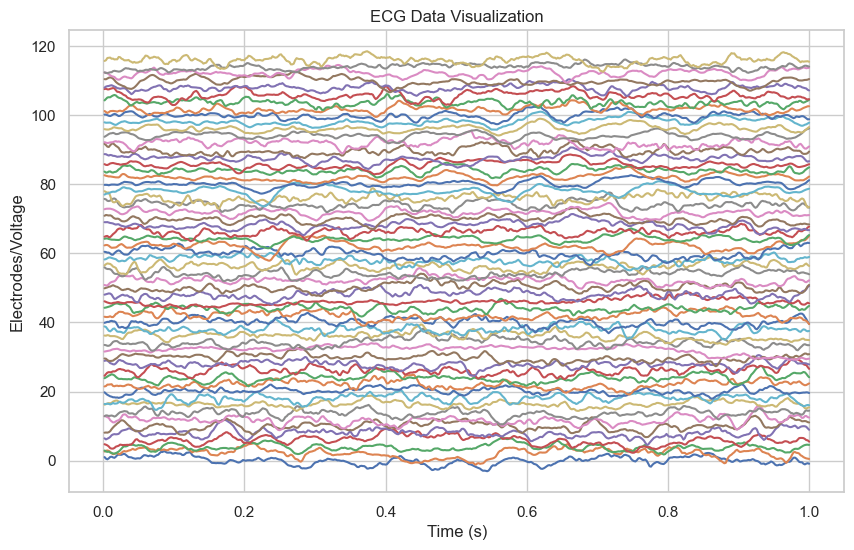

In [2]:
# load data from matlab file (from DMD: Theory & Applications)
data = loadmat('DATA/NEURO/ecog_window.mat')
data['X'] = np.array(data['X'])
X = data['X']
t = np.array(data['t'])

# plotting ECG for Data Viz
plt.figure(figsize=(10, 6))
for i in range(len(data['X'])):
    plt.plot(data['t'], data['X'][i] + i*2)#, color='blue')
    
plt.xlabel('Time (s)')
plt.ylabel('Electrodes/Voltage')
plt.title('ECG Data Visualization')

The above plot shows the clearly nonlinear time-series system. The recordings are vertically shifted for viewing purposes.

#### Augment Rank of Data Matrix Using Delay Coordinates

DMD works on the assumption that the features of the state far exceed the number of snapshots, which is clearly not the case (59 < 500). To account for this, we employ delay coordinates by stacking time-shifted copies of the data matrix on top of one another to configure a tall & skinny matrix. This is workable solution because generally the dynamics of a system depend both on present and past states.

It is important to note that the choice of the delay parameter when stacking is important because a large delay parameter better approximates long-term dynamics and vice versa. In accordance with the book, I use a delay parameter of one time-step and create 15 stacks.

In [10]:
def aug_dmd(X, nstacks=17):
    '''Augments data-matrix by stacking time-shifted data'''
    
    # initialize empty list to collect augmented data rows
    XAug = []
    for n in range(nstacks):
        x_aug = X[:, n:len(X[0])-nstacks+n]
        XAug.append(x_aug)
        
    # stack data
    XAug = np.vstack(XAug)
    print(XAug.shape)
    
    return XAug

In [11]:
nst = 17 # no. of stacks
XAug = aug_dmd(X, nstacks=nst) # augmented data matrix
tA = t[:len(t)-nst] # adjusted time series

(1003, 483)


### Diagnostics

#### Examining SVD

We first examine the Scree Plot of the data matrix's SVD to obtain a rank parameter for the DMD that captures the most variance and filters noise.

In [12]:
def svd_plot(X):
    '''Plots a scree plot to analyze eigenvector contributions'''
    # normalizing
    X = normalize(X)
    
    # plotting using scipy svd
    plt.plot(scipy.linalg.svdvals(
        np.array([x.flatten() for x in X]).T))
    
    plt.xlabel('Rank')
    plt.ylabel('Contribution')
    plt.title('Scree Plot')

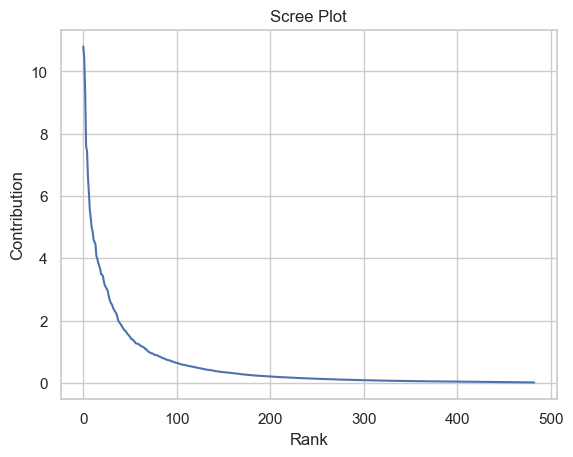

In [13]:
svd_plot(XAug)

Based on the above plot, we take rank = 200.

In [14]:
# initializing DMD object from PyDMD
rank = 200
dmd = DMD(svd_rank=rank, tlsq_rank=250, exact=True, opt=True) 

# fitting data to DMD model
dmd.fit(XAug) 

#### Recovering Modes & Dynamics

The code below plots the mode and corresponding dynamics for a given rank i.

In [ ]:
def plot_md(dmd, XAug, i=0):
    
    # creating time and mode ranges
    x = np.linspace(XAug.min(),XAug.max(), len(dmd.modes.T[0].real))
    t = np.linspace(0, 1, len(dmd.dynamics[0].real))
    
    # plotting the mode and corresponding dynamics
    fig, axs = plt.subplots(2, 1)
    
    mode = dmd.modes.T[i]
    axs[0].plot(x, mode.real)
    axs[0].set_title("Modes")
    
    plt.figure(figsize=(14, 6))
    dynamic = dmd.dynamics[i]
    axs[1].plot(t, dynamic.real)
    axs[1].set_title("Dynamics")
    
    fig.tight_layout()
    

The following GIF/plot surveys the 200 different modes and dynamics form the dataset.
![](https://i.imgur.com/wRU8l1I.gif)

### Reconstruction & Forecasting

Here we reconstruct the ECG recording from the decomposition as well as forecast a prediction into a future time-window. The code below creates two plots. One that shows an ensemble of recordings from the data and the other for one particular recording.

In [25]:
def recon_plot(X, X_t, X_rec, X_rec_t, XF=None, XF_t=None, limit=10, sp=5, comp=100):
    '''Creates a plot showing the DMD reconstruction in comparison to the true data
    for multiple recordings.
            Args:
                X: Original data matrix
                X_t: Time-series of original data matrix
                X_rec: Reconstructed data matrix
                X_rec_t: Time-series of reconstructed matrix
                XF: Optional forecasted data
                XF_t: Optional forecasted time-series
                limit: Limit to number of recordings for viewing
                sp: Spacing of recordings
                comp: rank of comparison dmd
    '''
    
    # comparison dmd
    dmd2 = DMD(svd_rank=comp, tlsq_rank=comp+50, exact=True, opt=True)
    dmd2.fit(XAug)
    XA_rec2 = dmd2.reconstructed_data
    
    # plotting data
    plt.figure(figsize=(10, 10))
    for i in range(limit):
        if i == 0:
            plt.plot(X_t, X[i] + i*sp, color='blue', label='True', alpha=0.2, linewidth=3)
            plt.plot(X_rec_t, X_rec[i] + i*sp, color='red', label='DMD(r=200)', linestyle='dotted')
            plt.plot(X_rec_t, XA_rec2[i] + i*sp, color='black', label=f'DMD(r={comp})',
             alpha=0.7, linestyle='dashed')
        else:
            plt.plot(X_t, X[i] + i*sp, color='blue', alpha=0.2, linewidth=3)
            plt.plot(X_rec_t, X_rec[i] + i*sp, color='red', linestyle='dotted')
            plt.plot(X_rec_t, XA_rec2[i] + i*sp, color='black',
             alpha=0.7, linestyle='dashed')
    
    # plotting forecasted data if available
    if XF is not None:
        plt.title(f'DMD Forecasting of ECG w split={split}')
        for i in range(limit):
            plt.plot(XF_t, XF[i] + i*sp, color='orange', alpha=0.5)
    else:
        plt.title(f'DMD Reconstruction of ECG w split={split}')
        
    plt.xlabel('Time (s)')
    plt.ylabel('Electrodes/Voltage')
    plt.legend()

def recon_plot2(X, X_t, X_rec, X_rec_t, XF=None, XF_t=None, n=0, comp=100):
    '''Creates a plot showing the DMD reconstruction in comparison to the true data
    for single recording.
            Args:
                X: Original data matrix
                X_t: Time-series of original data matrix
                X_rec: Reconstructed data matrix
                X_rec_t: Time-series of reconstructed matrix
                XF: Optional forecasted data
                XF_t: Optional forecasted time-series
                n: index of recording in data
                comp: rank of comparison dmd
    '''
    
    # comparison dmd
    dmd2 = DMD(svd_rank=comp, tlsq_rank=comp+50, exact=True, opt=True)
    dmd2.fit(XAug)
    XA_rec2 = dmd2.reconstructed_data
    
    # plotting data
    plt.figure(figsize=(10, 6))
    plt.plot(X_t, X[n], color='blue', label='True', alpha=0.2, linewidth=3)
    plt.plot(X_rec_t, XA_rec2[n], color='black', label=f'DMD(r={comp})',
             alpha=0.7, linestyle='dashed')
    plt.plot(X_rec_t, X_rec[n], color='red', label='DMD(r=200)', linestyle='dotted')
    
    # plotting forecasted data if available
    if XF is not None:
        plt.title(f'DMD Forecasting of ECG w split={split}')
        plt.plot(XF_t, XF[n], color='orange', alpha=0.5)
    else:
        plt.title(f'DMD Reconstruction of ECG w split={split}')
        
    plt.xlabel('Time (s)')
    plt.ylabel('Electrodes/Voltage')
    plt.legend()

Before plotting, we test the forecasting ability of DMD by splitting the data into a training and forecasting set.

In [18]:
def forecast_dmd(dmd, dt, XAug, split_index):
    '''Configures dmd object for forecasting'''
    
    dmd_forecast = copy.deepcopy(dmd)
    print("Shape before manipulation: {}".format(dmd_forecast.reconstructed_data.shape))
    dmd_forecast.dmd_time["dt"] *= dt
    dmd_forecast.dmd_time["tend"] *= XAug.shape[1]/split_index
    print("Shape after manipulation: {}".format(dmd_forecast.reconstructed_data.shape))
    
    return dmd_forecast

In [19]:
# split XAug into training and forecast data
split = 0.9
r = 150
split_index = int(XAug.shape[1]*split)

XAug_train = XAug[:, :split_index]
XAug_forecast = XAug[:, split_index:]

tA_train = tA[:split_index]
tA_forecast = tA[split_index:]

dmd_f = DMD(svd_rank=r, tlsq_rank=r+50, exact=True, opt=True)
dmd_f.fit(XAug_train)

# It is necessary to deepcopy the dmd object when generating
# the dmd forecast to avoid overwriting the reconstruction.
dmd_fc = forecast_dmd(dmd_f, dt=1, XAug=XAug, split_index=split_index)

print(XAug_train.shape, tA_train.shape)
print(XAug_forecast.shape, tA_forecast.shape)

Shape before manipulation: (1003, 434)
Shape after manipulation: (1003, 483)
(1003, 434) (434,)
(1003, 49) (49,)


The following GIF/plot illustrates the forecasting for multiple signals. The yellow is the true forecast data.

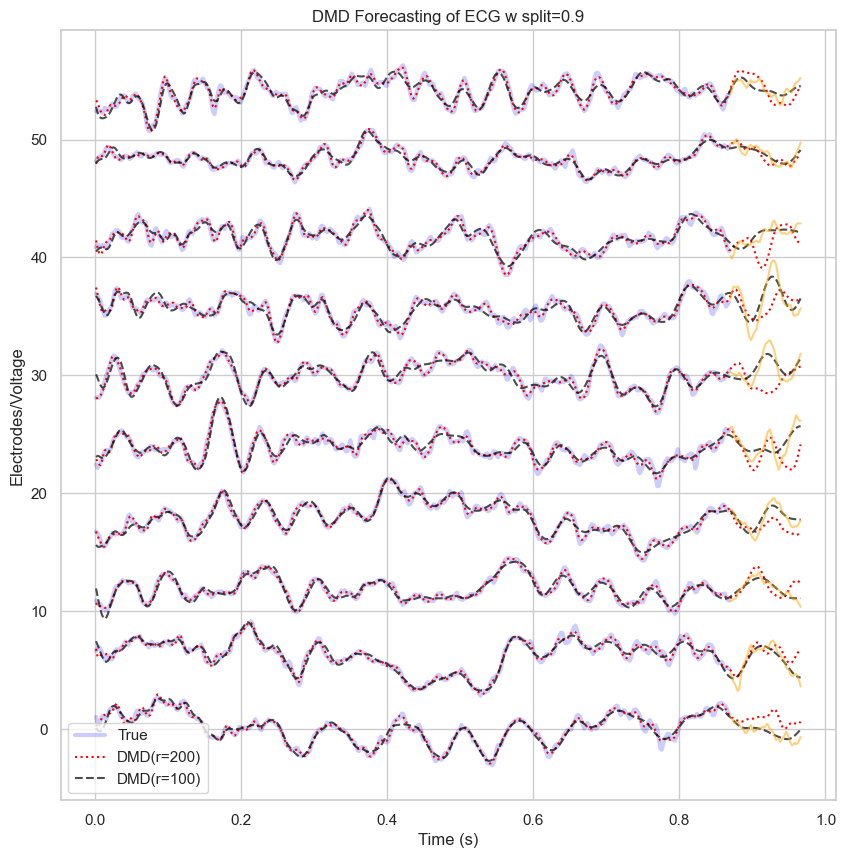

In [26]:
XAug_rec = dmd_fc.reconstructed_data
recon_plot(XAug_train, tA_train, XAug_rec, tA, XF=XAug_forecast, XF_t=tA_forecast, limit=10, sp=6)

The following GIF/plot illustrates the forecasting for a single signal. The yellow is the true data for the forecast.

![](https://i.imgur.com/bhPl5O8.gif)

As we above, the forecasting is powerful for an unsupervised method like DMD, at least for a short window into the future. Additionally, we see the classical case of overfitting, where a lower rank DMD sometimes outperforms a higher rank DMD when forecasting.

#### Bagging, Optimized Dynamic Mode Decomposition (BOP-DMD)

BOP-DMD takes several optimized DMD models and creates an ensemble for forecasting \[2\]. Each DMD model is trained on a random subset of the data matrix through a process called bootstrapping. This ultimately reduces overfitting and decreases variance with a potential performance boost similar to random forests in classical machine learning. Additionally, it provides measurements for uncertainties and standard deviations for each prediction. I briefly explore this for the dataset as follow:

In [ ]:
# initializing bopdmd model, num_trials indicates
# no. of DMD models in bagged ensemble
r = 200
bopdmd = BOPDMD(svd_rank=r, num_trials=100)
bopdmd.fit(XAug_train, tA_train)

# save obj on disc due to long training time
filehandler = open('bopdmd.obj', 'wb') 
pickle.dump(bopdmd, filehandler)

# Recovering the reconstruction uncertainty is most straight forward using
# the `forecast` method.
bopdmd_rec_mean, bopdmd_rec_variance = bopdmd.forecast(tA_train)

# Forecast the forecast period with BOP-DMD
bopdmd_f_mean, bopdmd_f_variance = bopdmd.forecast(tA_forecast)

The following plot illustrates BOPDMD's forecast:

![](https://i.imgur.com/NYuOFV0.png)

As we can see, BOPDMD didn't perform as well as exact DMD.

## Conclusion

Overall, I demonstrated some of the possibilities with DMD, a powerful tool to analyze nonlinear time-series data. Particularly, I explored it within the context of Neuroscience with ECG recordings. Whilst, the DMD textbook approaches the ECG data in a primarily diagnostic manner, I extended it and demonstrated forecasting as well. Additionally, this was all done in Python. While exact DMD showed promising forecasting results, BOPDMD was comparitively worse contrary to expectations due to its ensemble nature. One possible culprit for its poor performance is overfitting. Due to the long training time of BOPDMD, hyperparameter tuning, like the number of trials, was not explored in depth.

### Further Work

There is a lot to learn and explore with DMD. Being a data tool, it can be applied to a variety of domains like Financial Trading and other complex dynamical systems in physics like quantum time evolution. Additionally, other ensemble methods can be explored like Boosting with DMD. Finally, various parameters can be finetuned like the delay parameter and the number of splits.

## References

\[1\] Kutz, N. J., Brunton, S. L., Brunton, B. W., &amp; Proctor, J. L. (2017). Dynamic mode decomposition: Data-driven modeling of Complex Systems. Society for Industrial &amp; Applied Mathematics.

\[2\] Sashidhar, D., & Kutz, J. N. (2021). Bagging, optimized dynamic mode decomposition (BOP-DMD) for robust, stable forecasting with spatial and temporal uncertainty-quantification. ArXiv. https://doi.org/10.1098/rsta.2021.0199

I used PyDMD extensively in the project as well as their useful tutorials:
https://github.com/mathLab/PyDMD